<h1>Predicción del total de atletas de powerlifitng usando regresión Lineal</h1>

<h2>Busqueda de outlayers</h2>

In [ ]:
!pip install pandas seaborn matplotlib kaggle
!kaggle datasets download -d open-powerlifting/powerlifting-database


Dataset URL: https://www.kaggle.com/datasets/open-powerlifting/powerlifting-database
License(s): CC0-1.0
 98% 173M/176M [00:02<00:00, 95.1MB/s]
100% 176M/176M [00:02<00:00, 88.3MB/s]


['.config', 'powerlifting-database.zip', 'openpowerlifting-2024-01-06-4c732975.csv', 'openpowerlifting.csv', 'sample_data']


<ipython-input-23-2a11cb63b6db>:16: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


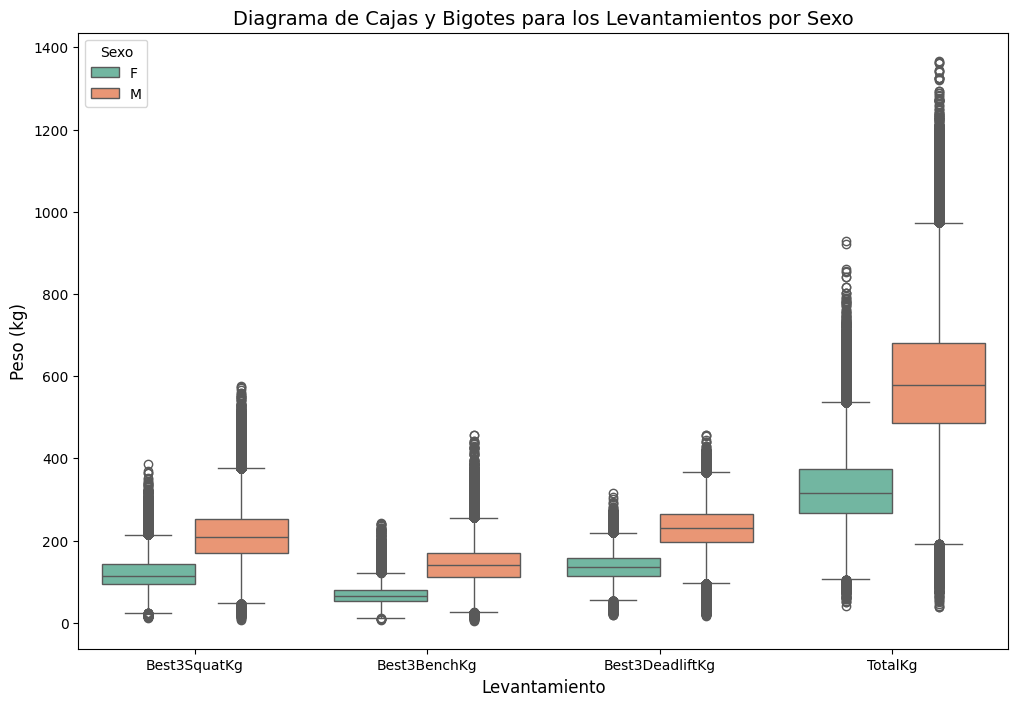

In [ ]:
import zipfile
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Descomprimir el archivo ZIP descargado
with zipfile.ZipFile('powerlifting-database.zip', 'r') as zip_ref:
    zip_ref.extractall('./')  # Esto extrae los archivos en el directorio actual

# Verificar los archivos extraídos
print(os.listdir('./'))

# Cargar el archivo CSV en un DataFrame
file_path = './openpowerlifting.csv'  # Ajusta esta ruta si es necesario
df = pd.read_csv(file_path)

# Filtrar solo los levantadores "Full Power"
df_full_power = df[df['Event'] == 'SBD']

# Seleccionar características relevantes
df_selected = df_full_power[['Age', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'Sex']]

# Eliminar valores negativos en los levantamientos
df_selected = df_selected[(df_selected['Best3SquatKg'] > 0) &
                          (df_selected['Best3BenchKg'] > 0) &
                          (df_selected['Best3DeadliftKg'] > 0)]

# Calcular el total levantado
df_selected['TotalKg'] = df_selected['Best3SquatKg'] + df_selected['Best3BenchKg'] + df_selected['Best3DeadliftKg']

# Eliminar filas con valores nulos
df_selected = df_selected.dropna()

# Transformar el DataFrame a formato largo para el boxplot
df_long = pd.melt(df_selected, id_vars=['Sex'], value_vars=['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg'],
                  var_name='Lift', value_name='Weight')

# Crear el diagrama de cajas y bigotes (Boxplot) para los levantamientos, diferenciando por sexo
plt.figure(figsize=(12, 8))
sns.boxplot(x='Lift', y='Weight', hue='Sex', data=df_long, palette='Set2')

# Añadir título y etiquetas
plt.title('Diagrama de Cajas y Bigotes para los Levantamientos por Sexo', fontsize=14)
plt.xlabel('Levantamiento', fontsize=12)
plt.ylabel('Peso (kg)', fontsize=12)

# Mostrar el gráfico
plt.legend(title='Sexo', loc='upper left')
plt.show()


<h2>Tratamiento de outlayers</h2>

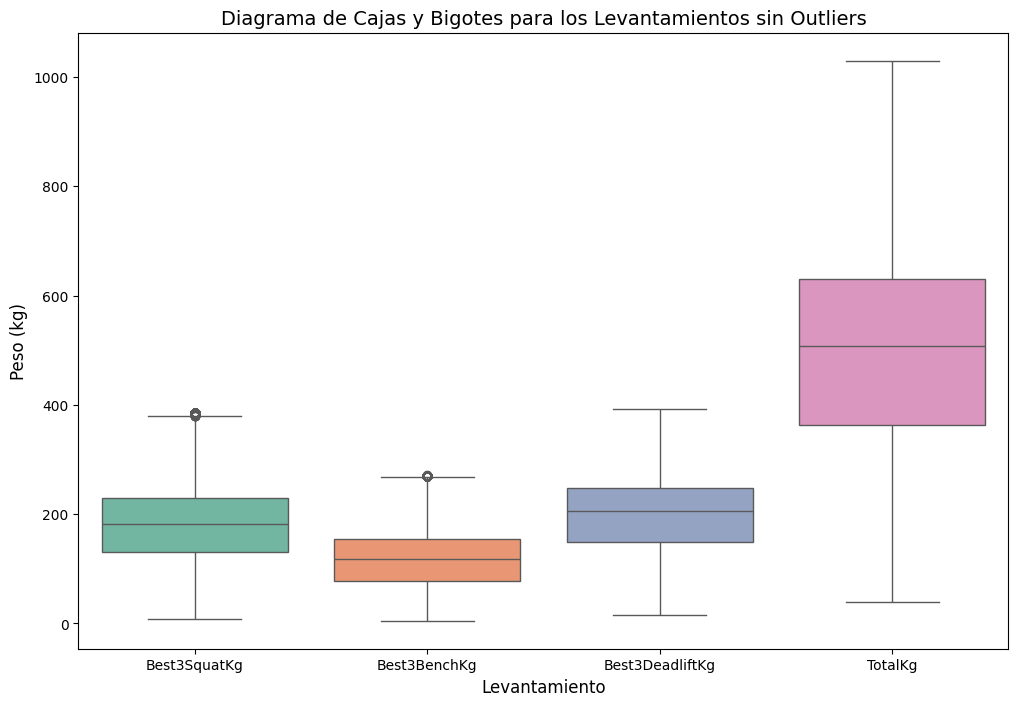

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Función para eliminar outliers utilizando el rango intercuartílico (IQR)
def eliminar_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Filtrar los valores fuera de 1.5 veces el IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Eliminar outliers en las columnas numéricas
df_selected_no_outliers = df_selected.copy()
for col in ['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg']:
    df_selected_no_outliers = eliminar_outliers(df_selected_no_outliers, col)

# Para la columna 'Sex', no se deben eliminar outliers, ya que es una variable categórica
# Ver las primeras filas del dataframe después de eliminar outliers
df_selected_no_outliers.head()

# Crear el diagrama de cajas y bigotes (Boxplot) sin outliers
plt.figure(figsize=(12, 8))

# Crear una lista con las columnas de los levantamientos y el total
columns = ['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg']

# Crear el boxplot para cada columna
sns.boxplot(data=df_selected_no_outliers[columns], palette='Set2')

# Añadir título y etiquetas
plt.title('Diagrama de Cajas y Bigotes para los Levantamientos sin Outliers', fontsize=14)
plt.xlabel('Levantamiento', fontsize=12)
plt.ylabel('Peso (kg)', fontsize=12)

# Mostrar el gráfico
plt.show()


<h2>Matriz de correlación </h2>

                      Age       Sex  BodyweightKg  Best3SquatKg  Best3BenchKg  \
Age              1.000000  0.005862      0.135934      0.010893      0.079107   
Sex              0.005862  1.000000      0.457763      0.599840      0.667982   
BodyweightKg     0.135934  0.457763      1.000000      0.616720      0.644380   
Best3SquatKg     0.010893  0.599840      0.616720      1.000000      0.902625   
Best3BenchKg     0.079107  0.667982      0.644380      0.902625      1.000000   
Best3DeadliftKg  0.039330  0.673572      0.626378      0.907271      0.874385   
TotalKg          0.040841  0.667054      0.650300      0.975452      0.953033   

                 Best3DeadliftKg   TotalKg  
Age                     0.039330  0.040841  
Sex                     0.673572  0.667054  
BodyweightKg            0.626378  0.650300  
Best3SquatKg            0.907271  0.975452  
Best3BenchKg            0.874385  0.953033  
Best3DeadliftKg         1.000000  0.963436  
TotalKg                 0.963436  1.

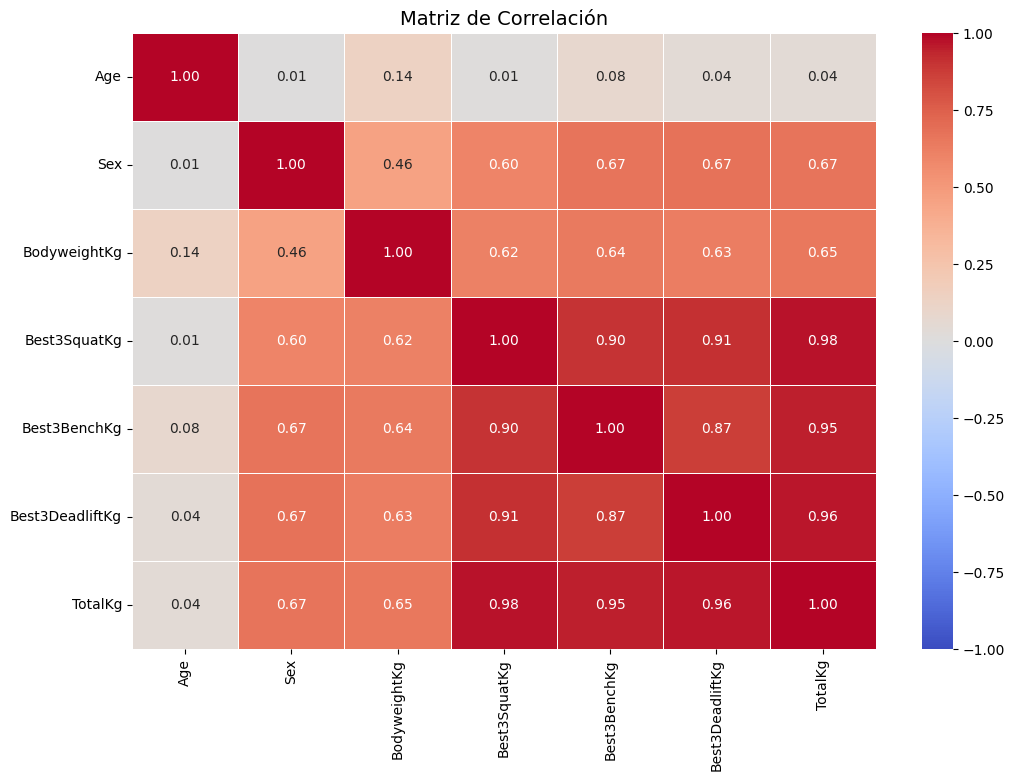

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Codificar la columna 'Sex' para que sea numérica (0 para 'F' y 1 para 'M')
df_selected_no_outliers['Sex'] = df_selected_no_outliers['Sex'].map({'F': 0, 'M': 1})

# Calcular la matriz de correlación
corr_matrix = df_selected_no_outliers[['Age', 'Sex', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg']].corr()

# Mostrar la matriz de correlación
print(corr_matrix)

# Crear el mapa de calor de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)

# Añadir título
plt.title('Matriz de Correlación', fontsize=14)

# Mostrar el gráfico
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'ruta/a/tu/dataset.csv'

In [ ]:
import numpy as np

# Supongamos que tenemos un atleta con las siguientes características:
# Peso (BodyweightKg) = 80 kg
# Sexo = 'M' (puedes cambiarlo a 'F' si es femenino)

bodyweight = 80  # Ejemplo de peso (en kg)
sex = 'F'  # Sexo (puede ser 'M' para masculino, 'F' para femenino)

# Convertir el sexo a un valor numérico (0 para femenino, 1 para masculino, si es necesario)
sex_value = 1 if sex == 'M' else 0

# Coeficientes del modelo
coef_squat = 1.00
coef_bench = 1.00
coef_deadlift = 1.00
coef_bodyweight = 0.00  # El coeficiente de bodyweight es 0, por lo que no afecta el resultado
coef_sex = 0.00  # El coeficiente de sexo es 0, por lo que tampoco afecta

# Predicción de los levantamientos (squat, bench press, deadlift) para este atleta
predicted_squat = coef_squat * bodyweight + coef_sex * sex_value
predicted_bench = coef_bench * bodyweight + coef_sex * sex_value
predicted_deadlift = coef_deadlift * bodyweight + coef_sex * sex_value

# Mostrar las predicciones
print(f"Predicción de Squat: {predicted_squat:.2f} kg")
print(f"Predicción de Bench Press: {predicted_bench:.2f} kg")
print(f"Predicción de Deadlift: {predicted_deadlift:.2f} kg")


Predicción de Squat: 80.00 kg
Predicción de Bench Press: 80.00 kg
Predicción de Deadlift: 80.00 kg


<ipython-input-35-6a7021d843ea>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sex'] = df['Sex'].map({'F': 0, 'M': 1})


Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.02

Coeficientes del modelo de regresión lineal:
Best3SquatKg: 1.00
Best3BenchKg: 1.00
Best3DeadliftKg: 1.00
BodyweightKg: 0.00
Sex: 0.00


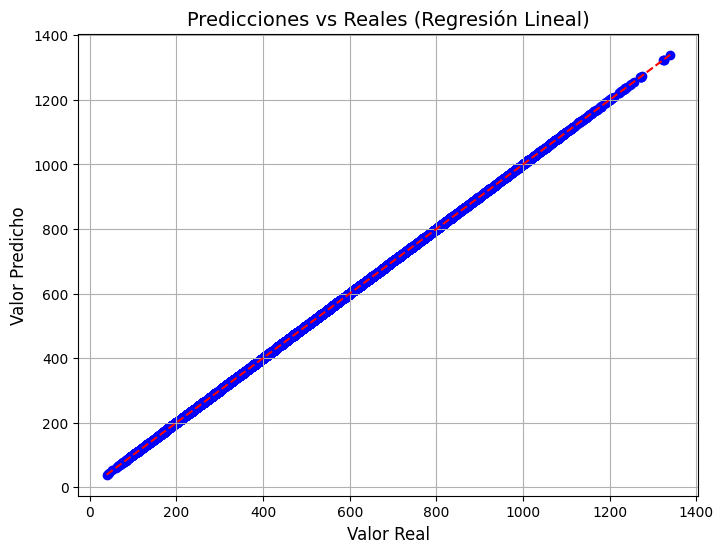

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Cargar los datos (reemplaza 'df' con tu DataFrame si ya lo tienes cargado)
# df = pd.read_csv('ruta_del_archivo.csv')  # Cargar tus datos aquí

# Seleccionar las variables independientes y dependiente
X_reduced = df[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']]
y = df['TotalKg']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Crear y ajustar el modelo de regresión lineal
model_reduced = LinearRegression()
model_reduced.fit(X_train_reduced, y_train_reduced)

# Obtener los coeficientes y el intercepto
coef_reduced = model_reduced.coef_
intercept_reduced = model_reduced.intercept_

# Imprimir resultados
print("Coeficientes:", coef_reduced)
print("Intercepto:", intercept_reduced)


NameError: name 'df' is not defined

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Cargar los datos (reemplaza 'df' con tu DataFrame si ya lo tienes cargado)
# df = pd.read_csv('ruta_del_archivo.csv')  # Cargar tus datos aquí

# Seleccionar las variables independientes y dependiente
X_reduced = df[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']]
y = df['TotalKg']

# Eliminar filas con valores nulos en las columnas seleccionadas
df_cleaned = df.dropna(subset=['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg'])

# Volver a asignar X_reduced y y después de la limpieza
X_reduced = df_cleaned[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']]
y = df_cleaned['TotalKg']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Crear y ajustar el modelo de regresión lineal
model_reduced = LinearRegression()
model_reduced.fit(X_train_reduced, y_train_reduced)

# Obtener los coeficientes y el intercepto
coef_reduced = model_reduced.coef_
intercept_reduced = model_reduced.intercept_

# Imprimir resultados
print("Coeficientes:", coef_reduced)
print("Intercepto:", intercept_reduced)


Coeficientes: [0.99999762 0.99999645 0.99999966]
Intercepto: 0.0002197102523950889


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Cargar los datos (si ya lo tienes cargado en el DataFrame df)
# df = pd.read_csv('ruta_del_archivo.csv')  # Cargar tus datos aquí

# Limpiar el DataFrame eliminando filas con valores nulos en las columnas relevantes
df_cleaned = df.dropna(subset=['TotalKg', 'Sex', 'BodyweightKg'])

# Convertir la columna 'Sex' a valores numéricos (0 para masculino, 1 para femenino)
le = LabelEncoder()
df_cleaned['Sex'] = le.fit_transform(df_cleaned['Sex'])  # 'F' -> 0, 'M' -> 1

# Seleccionar las variables independientes, solo incluyendo 'Sex' y 'BodyweightKg'
X = df_cleaned[['Sex', 'BodyweightKg']]

# Variable dependiente (Total levantado)
y = df_cleaned['TotalKg']

# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Imprimir los coeficientes e intercepto
print(f"Coeficientes: {model.coef_}")
print(f"Intercepto: {model.intercept_}")

# Ahora, supongamos que tienes los datos de una persona X con su sexo y peso corporal:
persona_x = pd.DataFrame({
    'Sex': [0],
    'BodyweightKg': [85]  # Ejemplo de peso corporal
})

# Hacer una predicción del total levantado para Persona X
prediccion_total = model.predict(persona_x)
print(f"Predicción del total levantado por Persona X: {prediccion_total[0]:.2f} Kg")


Coeficientes: [161.67289162   3.44143626]
Intercepto: 67.90196089854658
Predicción del total levantado por Persona X: 360.42 Kg


<ipython-input-34-06ead7ba448c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Sex'] = le.fit_transform(df_cleaned['Sex'])  # 'M' -> 0, 'F' -> 1


In [ ]:
!pip install mlcroissant

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.0 MB/s eta 0:00:00
  Created wheel for jsonpath-rw: filename=jsonpath_rw-1.4.0-py3-none-any.whl size=15130 sha256=81144f8ad1c8a8464cf720bd381e514a8c4b3f6adebfda819e02b71de5d250a5
  Stored in directory: /root/.cache/pip/wheels/e3/76/6f/c25be6a9e6cc9985b96e8c95997d46790242c6426ef68e754c
Successfully built jsonpath-rw


Categoria
Avanzado        121828
Novato          117668
Intermedio      100919
Élite            65219
Principiante     39451
Name: count, dtype: int64


<ipython-input-14-e2fc09d4a4d6>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Categoria', data=df_selected, palette='Set2', order=['Novato', 'Principiante', 'Intermedio', 'Avanzado', 'Élite'])


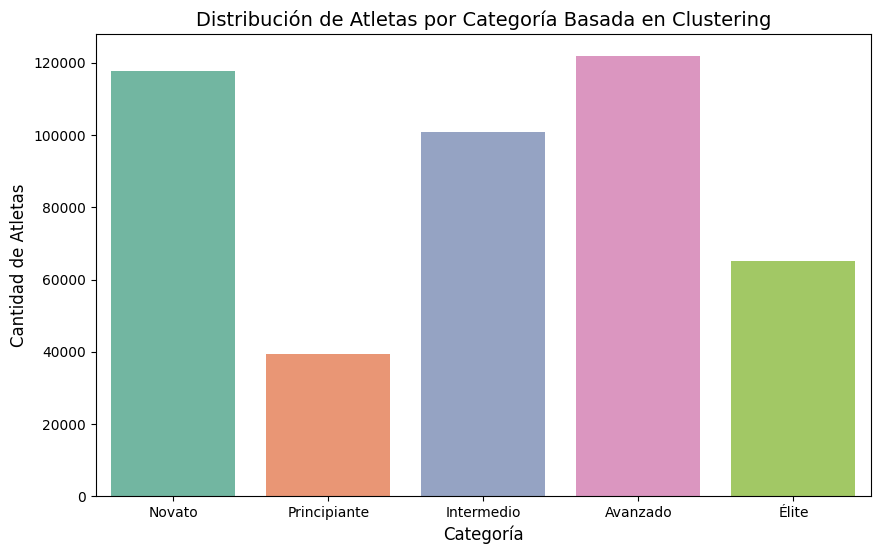

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Supongamos que df_selected ya contiene los datos preprocesados, incluyendo 'TotalKg'

# Seleccionar las características relevantes para el clustering
X = df_selected[['BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg']]

# Escalar los datos para el clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar KMeans con un número de clusters deseado (por ejemplo, 5)
kmeans = KMeans(n_clusters=5, random_state=42)
df_selected['Cluster'] = kmeans.fit_predict(X_scaled)

# Asignar nombres de categorías a los clusters basados en el total promedio de cada cluster
cluster_labels = df_selected.groupby('Cluster')['TotalKg'].mean().sort_values().index
cluster_map = {cluster: label for label, cluster in zip(['Novato', 'Principiante', 'Intermedio', 'Avanzado', 'Élite'], cluster_labels)}

# Mapear los clusters a las categorías
df_selected['Categoria'] = df_selected['Cluster'].map(cluster_map)

# Verificar la distribución de las categorías
print(df_selected['Categoria'].value_counts())

# Visualizar la distribución de categorías
plt.figure(figsize=(10, 6))
sns.countplot(x='Categoria', data=df_selected, palette='Set2', order=['Novato', 'Principiante', 'Intermedio', 'Avanzado', 'Élite'])
plt.title('Distribución de Atletas por Categoría Basada en Clustering', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Cantidad de Atletas', fontsize=12)
plt.show()
